## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy.linalg import multi_dot
from sklearn.metrics.pairwise import rbf_kernel

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question 3: Gaussian Processes and Hyper Parameter Tuning

Now for this problem, you will implement a basic Gaussian Progress Regression. We will be using the
standard radial basis kernel:
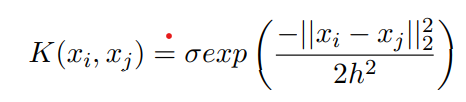


where σ, h are known as the scale and bandwith parameters.
So your implementation will be tested on the Concrete Compressive Strength dataset from the UCI
repository (which is the data repository I announced before, but we will attach the dataset). The
strength of concrete is predicted from 8 features consisting of the ingredients that make up the concrete
composition and its age.

### Load data

In [31]:
df_conc = pd.read_excel('Concrete_Data.xls')
print("The number of rows in data : {}".format(df_conc.shape[0]))
print("The number of columns in data : {}".format(df_conc.shape[1]))
print("The first few rows of the data:")
df_conc.head()

The number of rows in data : 1030
The number of columns in data : 9
The first few rows of the data:


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [32]:
# Creating feature and target datasets
y = df_conc[['Concrete compressive strength(MPa, megapascals) ']]
y.head(2)

X = df_conc.drop(columns = ['Concrete compressive strength(MPa, megapascals) '])
X.head(2)

,"Concrete compressive strength(MPa, megapascals)"
0,79.986111
1,61.887366


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

Get your hyperparameters by using your implemented HyperParameters functions and searching over the space of hs = logspace(-1,1,10)*norm(std(XTrain)) and sigmas = logspace(-1,1,10)*std(yTrain)

In [34]:
# Creating an array of h's
hs = np.logspace(-1,1,10)*np.linalg.norm(np.std(X_train))
print('hs array:',hs)

# Creating an array of sigma's
sigmas = np.logspace(-1,1,10)*np.std(y_train)[0]
print('sigmas array:',sigmas)

hs array: [  19.66064233   32.79592804   54.70690517   91.25661791  152.22521336
  253.92696018  423.57569868  706.56685051 1178.6245429  1966.06423317]
sigmas array: [  1.68181291   2.80543301   4.67974431   7.806284    13.02166654
  21.72144895  36.23356067  60.44122202 100.82203492 168.18129061]


Implement [K] = RBF Kernel(X1, X2, sigma, h) which takes as input two matrices of examples
X1 (n1× D),X2 (n2× D) with hyperparameters σ, h, and outputs the kernel matrix where Ki,j =
k(X1
i
, X2
j
), where k is the RBF function described above.


### RBF Kernel implementation

In [62]:
# Function to generate RBF kernel
def rbfKernel(x, y, sigma, h):
  k = sigma*np.exp((-np.sum((y-x[:,np.newaxis])**2,axis=-1))/2*(h**2))
  return k

In this step, you need to find hyperparameters for the Gaussian Process. One reasonable method
for Gaussian processes is to choose parameters that maximizes the log marginal likelihood. First
implement [logml] = LogMarinalLikelihood(XTrain, yTrain, sigma, h) which computes the log
marginal likelihood of the training data given the parameters.


### Log marginial likelihood calculation

In [56]:
# Function to find log marginal likelihood
def LogMarinalLikelihood(X_train, y_train,sigma,h):
  K = rbfKernel(X_train.values, X_train.values, sigma, h)
  N = len(X_train)
  noise = 0.1*np.std(y_train)[0]
  L = np.linalg.cholesky(K+noise*np.identity(N))
  L_inv = np.linalg.inv(L)
  logml = (0.5*(multi_dot([y_train.values.T,L_inv,y_train.values]) + np.log(np.linalg.det(L)) + N*np.log(2*np.pi)))[0][0]
  return logml

Implement [h, sigma] = HyperParameters(XTrain, yTrain, hs, sigmas), which does a grid search across the parameters in hs, sigmas and returns the combination that minimizes the log marginal likelihood (here you can just call the grid search function provided by Python).

### Hyperparameter tuning implementation

In [57]:
# Function to find hyperparameters that minimizes the log marginal likelihood
def hyperParameters(X_train,y_train,sigmas,hs):
  array1 = []
  for i in sigmas:
    for j in hs:
      array2 = []
      logml = LogMarinalLikelihood(X_train, y_train,i,j)
      array2.append(i)
      array2.append(j)
      array2.append(logml)
      array1.append(array2)

  df_mle = pd.DataFrame(array1, columns=['Sigma', 'h', 'mle'])
  sigma = df_mle.loc[df_mle['mle'].idxmin()]['Sigma']
  h = df_mle.loc[df_mle['mle'].idxmin()]['h']
  return sigma,h

Implement [GPMean, GPVariance] = GPRegression(XTrain, yTrain, XTest, sigma, h) which
carries out the Gaussian Process regression and returns the estimated mean and variances for the
variables in XTest. See page 19 of chapter 2 in Rasmussen and Williams for help on making this
computationally efficient and numerically stable.

### Gaussion process regression model implementation

In [58]:
# Function for Gaussian Process Regression with Radial Basis Kernel
def GPRegression(X,Xtest,y,sigma,h):
  N, n = len(X), len(Xtest)
  K = rbfKernel(X, X, sigma, h)
  noise = 0.1*np.std(y)[0]
  L = np.linalg.cholesky(K+noise*np.identity(N))
  L_inv = np.linalg.solve(L, rbfKernel(X, Xtest, sigma, h))
  # Computing mean
  mu = np.dot(L_inv.T, np.linalg.solve(L, y))
  # Computing variance
  K_test = rbfKernel(Xtest, Xtest, sigma, h)
  var = np.sqrt(np.diag(K_test) - np.sum(L_inv**2, axis=0))
  return mu, var

Run your Gaussian process regression method on the dataset provided. Compare and report
your results with a naive mean prediction. 

In [59]:
# Fubction to calculate model score
def score(X_train,X_test,y_test,sigma,h):
  mu, var = GPRegression(X_train,X_test,y_train,sigma,h)
  RMSE = np.sqrt(np.mean((mu-y_test.values)**2))
  print("The RMSE Score is :",round(RMSE,3))

In [60]:
# Calculating hyperparameters  that minimize the log marginal likelihood 
sigma,h = hyperParameters(X_train,y_train,sigmas,hs)

# Fitting the Gaussian Progress Regression model and getting the RMSE score
score(X_train,X_test,y_test,sigma,h)

The RMSE Score is : 5.697
